# 2C-ICE, DARDAR, and CCIC (GridSat) data from collocations

This notebook computes monthly mean timeseries from preprocessed CloudSat files (DARDAR and 2C-ICE)

In [5]:
import numpy as np
import xarray as xr
import os
import fnmatch 
import calendar
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

In [6]:
# path to preprocessed data
input_dir = '/scratch/ccic_record/data/cloudsat/cloudsat_collocations/'

# path to store output data
output_dir = '/scratch/ccic_record/data/processed/'
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

mask = xr.load_dataset('/scratch/ccic_record/data/mask_24.nc').mask

In [71]:
variables = [
    'iwp_ccic',
    'iwp_2cice',
    'iwp_dardar',
    'cloud_mask_ccic',
    'cloud_mask_2cice',
    'cloud_mask_dardar',
]

In [72]:
from pathlib import Path

from tqdm import tqdm

tiwp_sum_ccic = {}
tiwp_cts_ccic = {}
tiwp_sum_2cice = {}
tiwp_cts_2cice = {}
tiwp_sum_dardar = {}
tiwp_cts_dardar = {}

ca_sum_ccic = {}
ca_cts_ccic = {}
ca_sum_2cice = {}
ca_cts_2cice = {}
ca_sum_dardar = {}
ca_cts_dardar = {}

N_LATS = 180
N_LONS = 360
lat_bins = np.linspace(-90, 90, N_LATS + 1)
lon_bins = np.linspace(-180, 180, N_LONS + 1)

collocation_files = sorted(list(Path("/scratch/ccic_record/data/cloudsat/cloudsat_collocations/").glob("*.nc")))
for path in tqdm(collocation_files):
    
    colloc_data = xr.load_dataset(path)
    valid =  np.isfinite(colloc_data.cloud_mask_2cice.data)
    colloc_data = colloc_data[{"rays": valid}]

    years = list(np.unique(colloc_data.time.dt.year.data))
    for year in years:
        inds = colloc_data.time.dt.year.data == year
        colloc_data_yr = colloc_data[{"rays": inds}]
        months = list(np.unique(colloc_data_yr.time.dt.month.data))
        for month in months:
            inds = colloc_data_yr.time.dt.month.data == month
            colloc_data_m = colloc_data_yr[{"rays": inds}]
            lons = colloc_data_m.longitude.data
            lats = colloc_data_m.latitude.data

            # TIWP
            tiwp = colloc_data_m.iwp_2cice
            tiwp_sum = tiwp_sum_2cice.setdefault((year, month), np.zeros((N_LATS, N_LONS), np.float32))
            tiwp_cts = tiwp_cts_2cice.setdefault((year, month), np.zeros((N_LATS, N_LONS), np.float32))
            valid = (tiwp >= 0.0) * (tiwp < 1e3)
            tiwp_sum += np.histogram2d(lats[valid], lons[valid], bins=(lat_bins, lon_bins), weights=tiwp[valid])[0]
            tiwp_cts += np.histogram2d(lats[valid], lons[valid], bins=(lat_bins, lon_bins))[0]

            tiwp = colloc_data_m.iwp_dardar
            valid = (tiwp >= 0.0) * (tiwp < 1e3)
            tiwp_sum = tiwp_sum_dardar.setdefault((year, month), np.zeros((N_LATS, N_LONS), np.float32))
            tiwp_cts = tiwp_cts_dardar.setdefault((year, month), np.zeros((N_LATS, N_LONS), np.float32))
            tiwp_sum += np.histogram2d(lats[valid], lons[valid], bins=(lat_bins, lon_bins), weights=tiwp[valid])[0]
            tiwp_cts += np.histogram2d(lats[valid], lons[valid], bins=(lat_bins, lon_bins))[0]
            
            tiwp = colloc_data_m.iwp_ccic
            tiwp_sum = tiwp_sum_ccic.setdefault((year, month), np.zeros((N_LATS, N_LONS), np.float32))
            tiwp_cts = tiwp_cts_ccic.setdefault((year, month), np.zeros((N_LATS, N_LONS), np.float32))
            tiwp_sum += np.histogram2d(lats, lons, bins=(lat_bins, lon_bins), weights=tiwp)[0]
            tiwp_cts += np.histogram2d(lats, lons, bins=(lat_bins, lon_bins))[0]

            # Cloud mask
            ca = colloc_data_m.cloud_mask_2cice
            ca_sum = ca_sum_2cice.setdefault((year, month), np.zeros((N_LATS, N_LONS), np.float32))
            ca_cts = ca_cts_2cice.setdefault((year, month), np.zeros((N_LATS, N_LONS), np.float32))
            ca_sum += np.histogram2d(lats, lons, bins=(lat_bins, lon_bins), weights=ca)[0]
            ca_cts += np.histogram2d(lats, lons, bins=(lat_bins, lon_bins))[0]

            ca = colloc_data_m.cloud_mask_dardar
            ca_sum = ca_sum_dardar.setdefault((year, month), np.zeros((N_LATS, N_LONS), np.float32))
            ca_cts = ca_cts_dardar.setdefault((year, month), np.zeros((N_LATS, N_LONS), np.float32))
            ca_sum += np.histogram2d(lats, lons, bins=(lat_bins, lon_bins), weights=ca)[0]
            ca_cts += np.histogram2d(lats, lons, bins=(lat_bins, lon_bins))[0]
            
            ca = colloc_data_m.cloud_mask_ccic
            ca_sum = ca_sum_ccic.setdefault((year, month), np.zeros((N_LATS, N_LONS), np.float32))
            ca_cts = ca_cts_ccic.setdefault((year, month), np.zeros((N_LATS, N_LONS), np.float32))
            ca_sum += np.histogram2d(lats, lons, bins=(lat_bins, lon_bins), weights=ca)[0]
            ca_cts += np.histogram2d(lats, lons, bins=(lat_bins, lon_bins))[0]

# Combine data into arrays
dates = [np.datetime64(f"{year}-{month:02}-01") for year, month in tiwp_sum_2cice.keys()]
tiwp_sum_ccic = np.stack(list(tiwp_sum_ccic.values()))
tiwp_cts_ccic = np.stack(list(tiwp_cts_ccic.values()))
tiwp_sum_2cice = np.stack(list(tiwp_sum_2cice.values()))
tiwp_cts_2cice = np.stack(list(tiwp_cts_2cice.values()))
tiwp_sum_dardar = np.stack(list(tiwp_sum_dardar.values()))
tiwp_cts_dardar = np.stack(list(tiwp_cts_dardar.values()))
ca_sum_ccic = np.stack(list(ca_sum_ccic.values()))
ca_cts_ccic = np.stack(list(ca_cts_ccic.values()))
ca_sum_2cice = np.stack(list(ca_sum_2cice.values()))
ca_cts_2cice = np.stack(list(ca_cts_2cice.values()))
ca_sum_dardar = np.stack(list(ca_sum_dardar.values()))
ca_cts_dardar = np.stack(list(ca_cts_dardar.values()))

100%|███████████████████████████████████████████████████| 45767/45767 [20:09<00:00, 37.83it/s]


In [136]:
results = xr.Dataset()

In [137]:
lons = 0.5 * (lon_bins[1:] + lon_bins[:-1])
lats = 0.5 * (lat_bins[1:] + lat_bins[:-1])

gridded = xr.Dataset({
    "time": (("time",), dates),
    "latitude": (("latitude",), lats),
    "longitude": (("longitude",), lons),
    "tiwp_sum_ccic": (("time", "latitude", "longitude"), tiwp_sum_ccic),
    "tiwp_cts_ccic": (("time", "latitude", "longitude"), tiwp_cts_ccic),
    "tiwp_sum_2cice": (("time", "latitude", "longitude"), tiwp_sum_2cice),
    "tiwp_cts_2cice": (("time", "latitude", "longitude"), tiwp_cts_2cice),
    "tiwp_sum_dardar": (("time", "latitude", "longitude"), tiwp_sum_dardar),
    "tiwp_cts_dardar": (("time", "latitude", "longitude"), tiwp_cts_dardar),
    "ca_sum_ccic": (("time", "latitude", "longitude"), ca_sum_ccic),
    "ca_cts_ccic": (("time", "latitude", "longitude"), ca_cts_ccic),
    "ca_sum_2cice": (("time", "latitude", "longitude"), ca_sum_2cice),
    "ca_cts_2cice": (("time", "latitude", "longitude"), ca_cts_2cice),
    "ca_sum_dardar": (("time", "latitude", "longitude"), ca_sum_dardar),
    "ca_cts_dardar": (("time", "latitude", "longitude"), ca_cts_dardar),
})

/tmp/ipykernel_694792/3231171213.py:4: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  gridded = xr.Dataset({


In [138]:
results_monthly = gridded.resample(time="ME").sum()
results["tiwp_monthly_ccic"] = results_monthly["tiwp_sum_ccic"] / results_monthly["tiwp_cts_ccic"]
results["tiwp_monthly_2cice"] = results_monthly["tiwp_sum_2cice"] / results_monthly["tiwp_cts_2cice"]
results["tiwp_monthly_dardar"] = results_monthly["tiwp_sum_dardar"] / results_monthly["tiwp_cts_dardar"]
results["ca_monthly_ccic"] = results_monthly["ca_sum_ccic"] / results_monthly["ca_cts_ccic"]
results["ca_monthly_2cice"] = results_monthly["ca_sum_2cice"] / results_monthly["ca_cts_2cice"]
results["ca_monthly_dardar"] = results_monthly["ca_sum_dardar"] / results_monthly["ca_cts_dardar"]

In [139]:
mask = xr.load_dataset("/scratch/ccic_record/data/mask_24.nc")

In [163]:
mask = mask.interp(longitude=results.longitude, latitude=results.latitude)
weights = np.cos(np.deg2rad(results.latitude))
tiwp_dardar = results.tiwp_monthly_dardar
tiwp_dardar.data[tiwp_dardar.data > 1e2] = np.nan
results["tiwp_mean_ccic"] = results["tiwp_monthly_ccic"].weighted(weights).mean(("latitude", "longitude"))
results["tiwp_mean_2cice"] = results["tiwp_monthly_2cice"].weighted(weights).mean(("latitude", "longitude"))
results["tiwp_mean_dardar"] = results["tiwp_monthly_dardar"].weighted(weights).mean(("latitude", "longitude"))
results["tiwp_masked_mean_ccic"] = results["tiwp_monthly_ccic"].where(mask.mask).weighted(weights).mean(("latitude", "longitude"))
results["tiwp_masked_mean_2cice"] = results["tiwp_monthly_2cice"].where(mask.mask).weighted(weights).mean(("latitude", "longitude"))
results["tiwp_masked_mean_dardar"] = results["tiwp_monthly_dardar"].where(mask.mask).weighted(weights).mean(("latitude", "longitude"))

In [164]:
for name in ["ccic", "dardar", "2cice"]:
    cts = results_monthly[f"tiwp_cts_{name}"].sum(("latitude", "longitude"))
    print(cts)
    results[f"tiwp_mean_{name}"].data[cts < 1e6] = np.nan
    results[f"tiwp_masked_mean_{name}"].data[cts < 1e6] = np.nan

<xarray.DataArray 'tiwp_cts_ccic' (time: 157)> Size: 628B
array([ 6029143., 10193707., 10373227., 10226110.,  4535989.,  4272664.,
        3613255., 11162709., 11642943., 10172967.,  9156818., 12419477.,
       12490461., 11280232., 12917753., 12344091., 12098198., 11876701.,
       11952734.,  9739510., 10603312.,  8792325., 12580402., 10747139.,
        9422903., 11456286., 12363564.,  9948209., 12213938., 12439122.,
       12743546., 12160063.,  6379286.,  6702625., 11241693., 12737720.,
       11669769., 12971600., 12056846., 12325615., 13092130., 12080587.,
        2709334.,  6095955., 11521362., 12126346., 12313827., 12974572.,
       12261333., 11828764., 10722645., 12080558., 12212928., 11407160.,
       12582609.,    21881.,  8407298.,  9142356.,  6733668.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,  2216573.,
        6321660.,  4074640.,  6598414.,  4917393.,  5848080.,  582

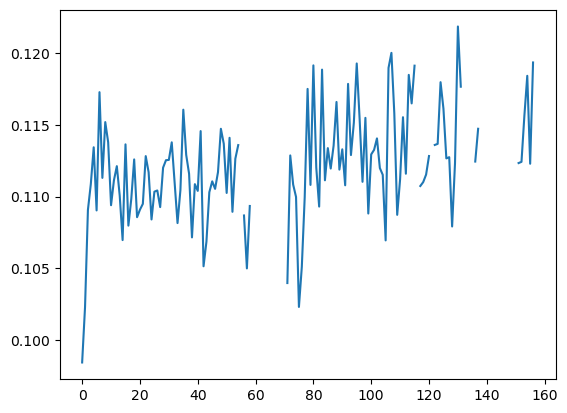

In [165]:
plt.plot(results["tiwp_mean_dardar"])

In [166]:
results_yearly = gridded.resample(time="1Y").sum().rename({"time": "year"})
results["tiwp_ccic_yearly"] = results_yearly["tiwp_sum_ccic"] / results_yearly["tiwp_cts_ccic"]
results["tiwp_2cice_yearly"] = results_yearly["tiwp_sum_2cice"] / results_yearly["tiwp_cts_2cice"]
results["tiwp_dardar_yearly"] = results_yearly["tiwp_sum_dardar"] / results_yearly["tiwp_cts_dardar"]
results["ca_ccic_yearly"] = results_yearly["ca_sum_ccic"] / results_yearly["ca_cts_ccic"]
results["ca_2cice_yearly"] = results_yearly["ca_sum_2cice"] / results_yearly["ca_cts_2cice"]
results["ca_dardar_yearly"] = results_yearly["ca_sum_dardar"] / results_yearly["ca_cts_dardar"]

/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [167]:
results_all = gridded.sum("time")
results["tiwp_ccic"] = results_all["tiwp_sum_ccic"] / results_all["tiwp_cts_ccic"]
results["tiwp_2cice"] = results_all["tiwp_sum_2cice"] / results_all["tiwp_cts_2cice"]
results["tiwp_dardar"] = results_all["tiwp_sum_dardar"] / results_all["tiwp_cts_dardar"]
results["ca_ccic"] = results_all["ca_sum_ccic"] / results_all["ca_cts_ccic"]
results["ca_2cice"] = results_all["ca_sum_2cice"] / results_all["ca_cts_2cice"]
results["ca_dardar"] = results_all["ca_sum_dardar"] / results_all["ca_cts_dardar"]

In [168]:
results_monthly = gridded.groupby(gridded.time.dt.month).sum()
results["tiwp_monthly_ccic"] = results_monthly["tiwp_sum_ccic"] / results_monthly["tiwp_cts_ccic"]
results["tiwp_monthly_2cice"] = results_monthly["tiwp_sum_2cice"] / results_monthly["tiwp_cts_2cice"]
results["tiwp_monthly_dardar"] = results_monthly["tiwp_sum_dardar"] / results_monthly["tiwp_cts_dardar"]

In [171]:
results.to_netcdf("/scratch/ccic_record/data/processed/cloudsat_time_series.nc")

# Global distributions

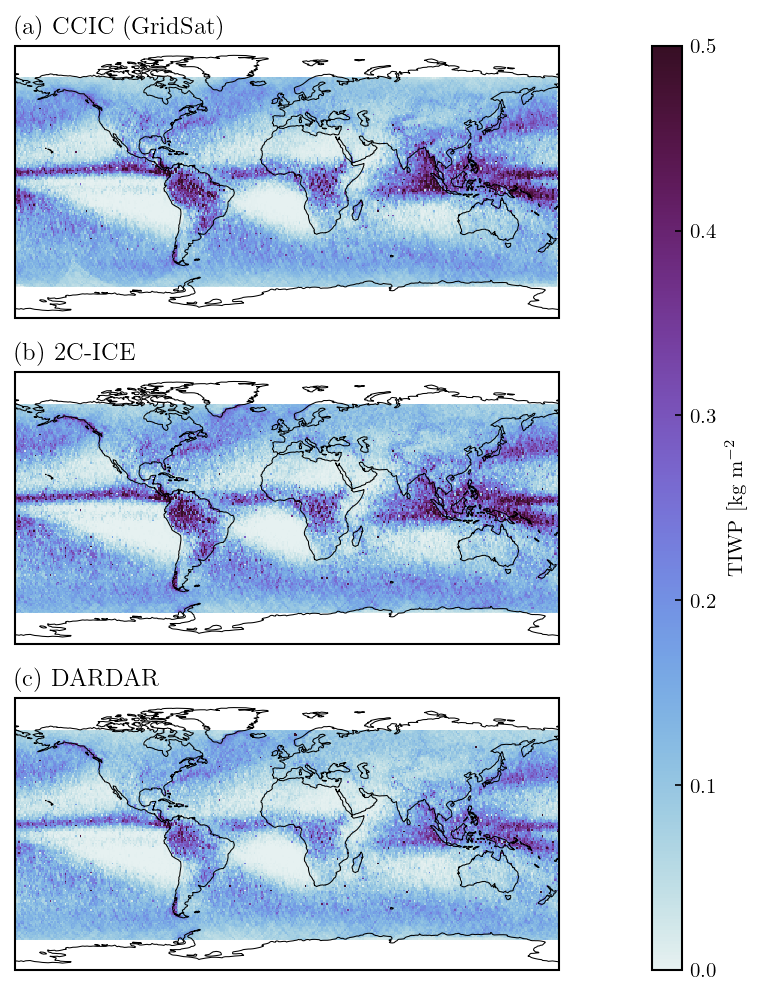

In [166]:
import cmocean
import matplotlib
from matplotlib.gridspec import gridspec
import cartopy.crs as ccrs
matplotlib.style.use("../ccic.mplstyle")

fig = plt.figure(figsize=(6, 8))
gs = gridspec(3, 2, width_ratios=[1.0, 0.05])
crs = ccrs.platecarree()

lons = results.longitude.data
lats = results.latitude.data

ax = fig.add_subplot(gs[0, 0], projection=crs)
ax.pcolormesh(lons, lats, results["tiwp_ccic"], vmin=0, vmax=0.5)
ax.set_title("(a) ccic (gridsat)")
ax.coastlines()

ax = fig.add_subplot(gs[1, 0], projection=crs)
ax.pcolormesh(lons, lats, results["tiwp_2cice"], vmin=0, vmax=0.5)
ax.set_title("(b) 2c-ice")
ax.coastlines()

ax = fig.add_subplot(gs[2, 0], projection=crs)
m = ax.pcolormesh(lons, lats, results["tiwp_dardar"], vmin=0, vmax=0.5)
ax.set_title("(c) dardar")
ax.coastlines()

ax = fig.add_subplot(gs[:, 1])
plt.colorbar(m, label="tiwp [kg m$^{-2}$", cax=ax)